In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import channel_optimization
import create_database
import sqlite3
import sys

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
#Check which python version used:
sys.version

'3.9.4 (default, Apr  9 2021, 09:32:38) \n[Clang 10.0.0 ]'

#### Data load and descriptive

In [3]:
#Load data:
df = pd.read_csv('data_agg.csv')

In [4]:
#check na
df.isna().sum()

id_something    0
contacts        0
channel_a       0
channel_b       0
channel_c       0
channel_d       0
sales           0
dtype: int64

In [5]:
df.describe()

,id_something,contacts,channel_a,channel_b,channel_c,channel_d,sales
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,176.000000,0.148802,0.141092,0.210496,0.146689,0.048735,0.236188
std,44.311398,0.141284,0.138436,0.198500,0.139474,0.124072,0.192996
min,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,138.000000,0.041667,0.032258,0.048259,0.041356,0.003003,0.076531
50%,176.000000,0.108333,0.103226,0.160660,0.107797,0.009009,0.210204
75%,214.000000,0.230556,0.212903,0.325596,0.231864,0.033033,0.353061
max,252.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


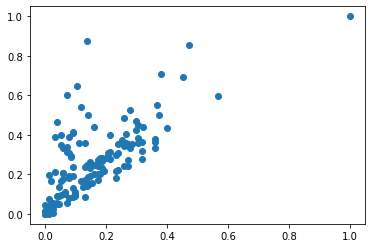

In [6]:
plt.scatter(df.channel_a, df.sales)

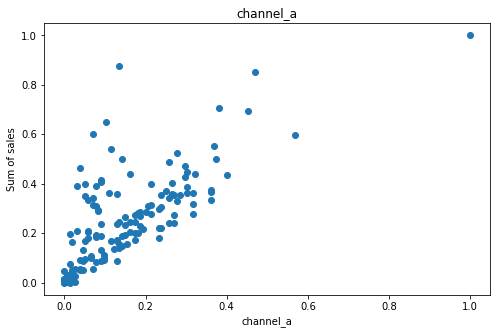

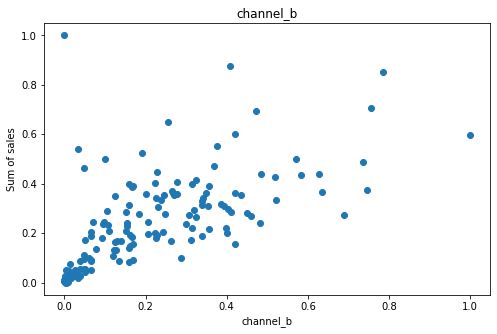

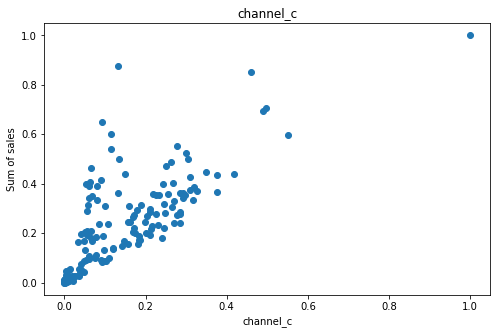

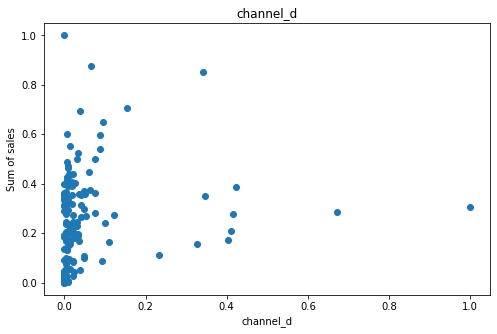

In [7]:
#plotting prescription sum vs underlying features:
indep_var = [
             'channel_a',
             'channel_b',
             'channel_c',
             'channel_d'
              ]

for i in indep_var:
    '''Plotting usage of channels vs sales'''
    plt.figure(figsize=(8,5))
    plt.title(i)
    plt.scatter(df[i], df.sales)
    plt.xlabel(i)
    plt.ylabel('Sum of sales')

In [8]:

#fit LR:
indep_var = [
             'channel_a',
             'channel_b',
             'channel_c',
             'channel_d'
              ]

target = 'sales'

X = df[indep_var]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Train the model using the training sets
lr_sales = sm.OLS(y_train, X_train).fit()
y_pred = lr_sales.predict(X_test)

#The mean squared error
print('Mean absolute error: %.2f'
      % metrics.mean_absolute_error(y_test, y_pred))
#The coefficient of determination: 1 is perfect prediction
print('r2: %.2f'
      % metrics.r2_score(y_test, y_pred))
print()
print()

lr_sales = sm.OLS(y, X).fit()
#lr = ElasticNet(alpha=1.0)
#lr = Ridge()
#lr.fit(X, y)

lr_pred = lr_sales.predict(X)
print(metrics.mean_absolute_error(y, lr_pred))
print(metrics.r2_score(y, lr_pred))
print()
print('Coefficients: \n', lr_sales.summary())
#lr.get_params()

Mean absolute error: 0.07
r2: 0.63


0.07877759741290129
0.571293240614229

Coefficients: 
                                  OLS Regression Results                                
Dep. Variable:                  sales   R-squared (uncentered):                   0.829
Model:                            OLS   Adj. R-squared (uncentered):              0.824
Method:                 Least Squares   F-statistic:                              180.6
Date:                Sat, 15 May 2021   Prob (F-statistic):                    4.47e-56
Time:                        20:41:59   Log-Likelihood:                          99.896
No. Observations:                 153   AIC:                                     -191.8
Df Residuals:                     149   BIC:                                     -179.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std

Text(0, 0.5, 'observed')

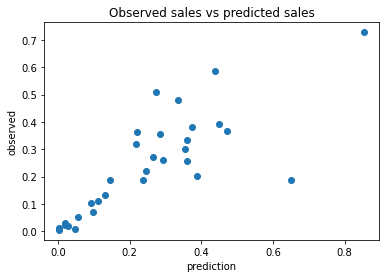

In [9]:
plt.scatter(y_test, y_pred)
plt.title('Observed sales vs predicted sales')
plt.xlabel('prediction')
plt.ylabel('observed')

Text(0.5, 1.0, 'pred vs true for whole dataset (overfitted)')

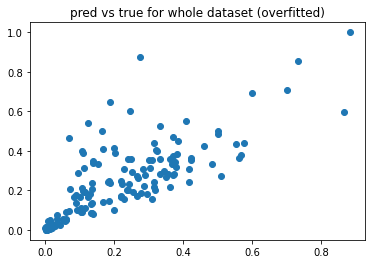

In [10]:
plt.scatter(lr_pred, y)
plt.title('pred vs true for whole dataset (overfitted)')

In [11]:
#Check multicollinearity:
norm_x = X_train.values
for i, name in enumerate(X):
    if name == "const":
        continue
    norm_x[:,i] = X_train[name]/np.linalg.norm(X_train[name])
norm_xtx = np.dot(norm_x.T,norm_x)

eigs = np.linalg.eigvals(norm_xtx)
condition_number = np.sqrt(eigs.max() / eigs.min())
print(condition_number) #values above 20 are critical

16.695923057980288


In [12]:
#predict number of customers based on channel activity:
#fit LR:
indep_var = [
             'channel_a',
             'channel_b',
             'channel_c',
             'channel_d'
              ]

target = 'contacts'

X = df[indep_var]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

lr_contacts = sm.OLS(y_train, X_train).fit()
y_pred = lr_contacts.predict(X_test)

# The mean squared error
print('Mean absolute error: %.2f'
      % metrics.mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('r2: %.2f'
      % metrics.r2_score(y_test, y_pred))
print()
print()

lr_contacts = sm.OLS(y, X).fit(intercept=True)
print('Coefficients: \n', lr_contacts.summary())

Mean absolute error: 0.01
r2: 0.99


Coefficients: 
                                  OLS Regression Results                                
Dep. Variable:               contacts   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.921e+04
Date:                Sat, 15 May 2021   Prob (F-statistic):                   5.54e-201
Time:                        20:42:00   Log-Likelihood:                          503.39
No. Observations:                 153   AIC:                                     -998.8
Df Residuals:                     149   BIC:                                     -986.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025 

Text(0, 0.5, 'observed')

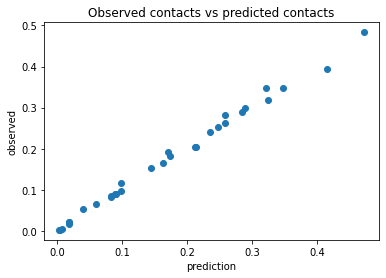

In [13]:
plt.scatter(y_pred, y_test)
plt.title('Observed contacts vs predicted contacts')
plt.xlabel('prediction')
plt.ylabel('observed')

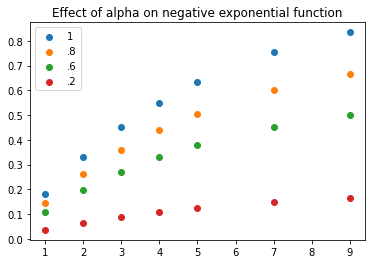

In [14]:
#Showing effect of diminishing marginal returns
#from negative exponential with varying alpha
def negative_exponential(x,alpha,beta):
    return [alpha*(1-np.exp(-beta*i)) for i in x]

def michaelis_menten(x,alpha):
    return [(alpha*i)/(1+0.78*i) for i in x]

x_list = [1,2,3,4,5,7,9]
alpha_list = [1, .8, .6, .2]
legend_list = ['1', '.8', '.6', '.2']

for i,v in enumerate(alpha_list):
    temp = negative_exponential(
                                x_list, alpha_list[i],
                                0.2
    )
    plt.scatter(x_list, temp, label=legend_list[i])
    
    plt.legend()
    plt.title('Effect of alpha on negative exponential function')

In [15]:
#save coefficients in lists
coef_sales = [lr_sales.params[0], 
              lr_sales.params[1],
              lr_sales.params[2],
              lr_sales.params[3]]

coef_contacts = [lr_contacts.params[0],
                 lr_contacts.params[1],
                 lr_contacts.params[2],
                 lr_contacts.params[3]]

In [16]:
alpha = 0.6
optimized_sales = []
opti_a = []
opti_b = []
opti_c = []
opti_d = []

for value in range(0, df.shape[0]):
    temp = [df.iloc[value][2],
         df.iloc[value][3],
         df.iloc[value][4],
         df.iloc[value][5]]

    cust_x = df.iloc[value][2]

    sq = channel_optimization.optimization(coef_sales,
                                           coef_contacts,
                                           temp,
                                           cust_x,
                                           alpha)
    sq.optimizer
    opti_temp = sq.optimizer(temp)
    optimized_sales.append(-sq.objective_function(opti_temp.x))
    opti_a.append(opti_temp.x[0])
    opti_b.append(opti_temp.x[1])
    opti_c.append(opti_temp.x[2])
    opti_d.append(opti_temp.x[3])
df['optimized_sales'] = optimized_sales  
df['optimized_a'] = opti_a
df['optimized_b'] = opti_b
df['optimized_c'] = opti_c
df['optimized_d'] = opti_d

<AxesSubplot:>

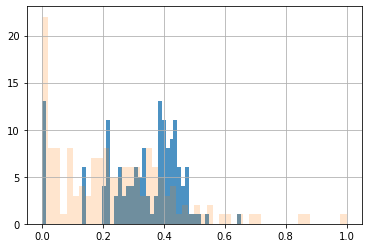

In [17]:
#Comparing initial and expected sales after optimization of channel activity
df.optimized_sales.hist(bins=50, alpha=0.8)
df.sales.hist(bins=50, alpha=.2)
plt.title('Comparing initial sales and expected sales after ')

In [18]:
df[['sales', 'optimized_sales']].describe()

,sales,optimized_sales
count,153.000000,153.000000
mean,0.236188,0.323801
std,0.192996,0.136516
min,0.000000,0.000000
25%,0.076531,0.250497
50%,0.210204,0.357596
75%,0.353061,0.420083
max,1.000000,0.653768


<AxesSubplot:>

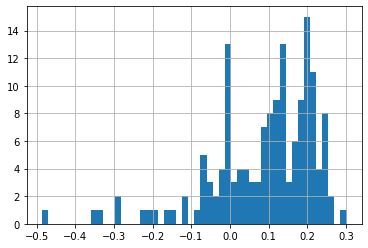

In [19]:
#Plotting histogram of simple delta between initial and 
#optimized sales
df['delta'] = df.optimized_sales - df.sales
df.delta.hist(bins=50)

In [21]:
#Upload channel recommendations for each sales id into database
df_upload = df[['id_something', 
                'optimized_a', 
                'optimized_b', 
                'optimized_c', 
                'optimized_d']]

db = create_database.database('channel_recommendations', 
              df_upload.columns, 
              df_upload)
db.create_db()

In [25]:
#Connect to database and download recommendations
conn_db = sqlite3.connect('channel_recommendations.db')

check = pd.read_sql_query("SELECT * FROM channel_recommendations",
                          conn_db)
check.sample(10)

,id_something,optimized_a,optimized_b,optimized_c,optimized_d
57,158.0,1.000000,1.0,0.162738,1.000000
32,133.0,1.000000,1.0,0.155602,1.000000
87,188.0,0.000000,1.0,0.000000,0.533387
143,244.0,0.177375,1.0,0.000000,1.000000
70,171.0,1.000000,1.0,0.119924,1.000000
100,201.0,0.177375,1.0,0.000000,1.000000
49,150.0,0.042446,1.0,0.000000,1.000000
8,109.0,0.312304,1.0,0.000000,1.000000
84,185.0,1.000000,1.0,0.119924,1.000000
18,119.0,1.000000,1.0,0.034297,1.000000
